In [7]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATA_PATH = "/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt"

In [26]:
from pathlib import Path

folder_path = Path(DATA_PATH)
all_files = [file for file in folder_path.rglob('*') if file.is_file()]

print(all_files)

[PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw3.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/fraw.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/cot.jsonl'), PosixPath('/playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl')]


In [ ]:
def clean_answer(answer):
    answer = answer.split("\n")[0]
    answer = answer.replace("$", "").strip()
    if "YES" in answer.upper():
        return "YES"
    elif "NO" in answer.upper():
        return "NO"
    else:
        return None

In [35]:
def return_ground_truth(label):
    if label == "indication":
        return "YES"
    elif label == "contraindication":
        return "NO"

In [46]:
def cal_acc(answer, ground_truth):
    if answer == ground_truth:
        acc_score = 1
    else:
        acc_score = 0

    return acc_score

In [51]:
def normalize_uncertainty_scores(scores):
    min_score = min(scores)
    max_score = max(scores)
    
    if max_score == min_score:
        return [0.0 for _ in scores]
    
    return [(s - min_score) / (max_score - min_score) for s in scores]


In [52]:
import numpy as np
import matplotlib.pyplot as plt

def create_calibration_plot(uncertainty_scores, accuracies, model_name):
    confidence_scores = normalize_uncertainty_scores(uncertainty_scores)
    
    bin_edges = np.linspace(0, 1, 11)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    bin_accuracies = np.zeros(len(bin_edges) - 1)
    bin_counts = np.zeros(len(bin_edges) - 1)
    
    for confidence, accuracy in zip(confidence_scores, accuracies):
        if confidence == 1.0:
            bin_idx = len(bin_edges) - 2
        else:
            bin_idx = int(confidence * 10)
        
        bin_accuracies[bin_idx] += accuracy
        bin_counts[bin_idx] += 1
    
    for i in range(len(bin_accuracies)):
        if bin_counts[i] > 0:
            bin_accuracies[i] /= bin_counts[i]
    
    perfect_calibration = bin_centers
    error = np.sum(np.abs(bin_accuracies - perfect_calibration) * bin_counts) / np.sum(bin_counts)
    error = round(error * 100, 1)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    
    bars = ax.bar(bin_centers, bin_accuracies, width=0.08, color='blue', edgecolor='black', label='Outputs')
    
    for i, (center, acc) in enumerate(zip(bin_centers, bin_accuracies)):
        if acc < center:
            ax.bar(center, center - acc, bottom=acc, width=0.08, color='lightpink', 
                  edgecolor='red', hatch='///', alpha=0.7, label='Gap' if i==0 else "")
        elif acc > center:
            ax.bar(center, acc - center, bottom=center, width=0.08, color='lightpink',
                  edgecolor='red', hatch='///', alpha=0.7, label='Gap' if i==0 else "")
        
        count = int(bin_counts[i])
        ax.text(center, max(acc + 0.03, center + 0.03), f'n={count}', 
                ha='center', va='bottom', fontsize=8, rotation=0)
    
    ax.plot([0, 1], [0, 1], linestyle='--', linewidth=2, color='gray')
    
    ax.text(0.5, 0.2, f"Error={error}", bbox=dict(facecolor='lightgray', alpha=0.8), fontsize=12)
    
    ax.set_title(f'Calibration Plot for {model_name}')
    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend()
    
    plt.show()  
    
    return error


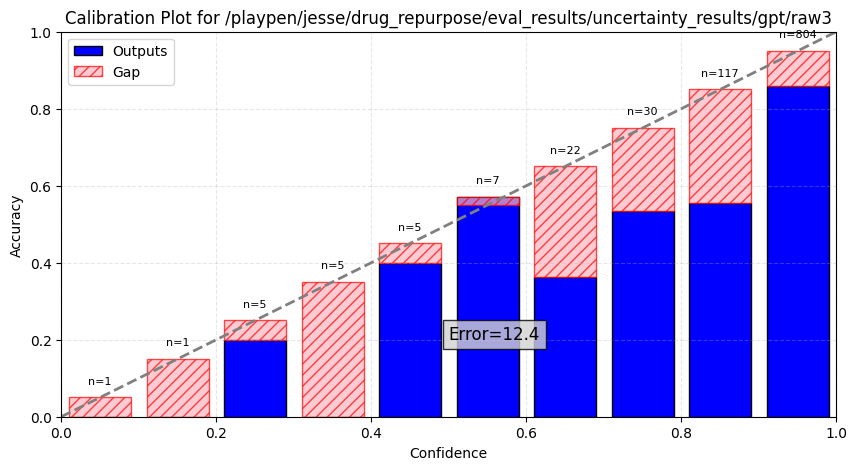

File: /playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw3.jsonl, Calibration Error: 12.4


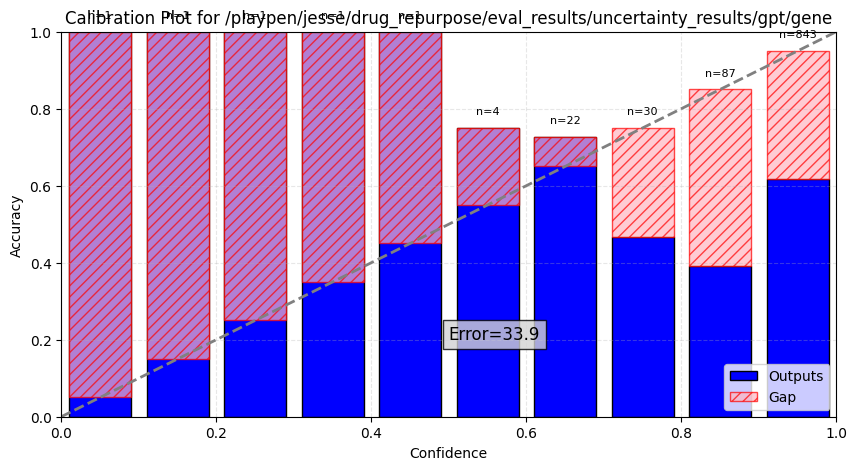

File: /playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/gene.jsonl, Calibration Error: 33.9


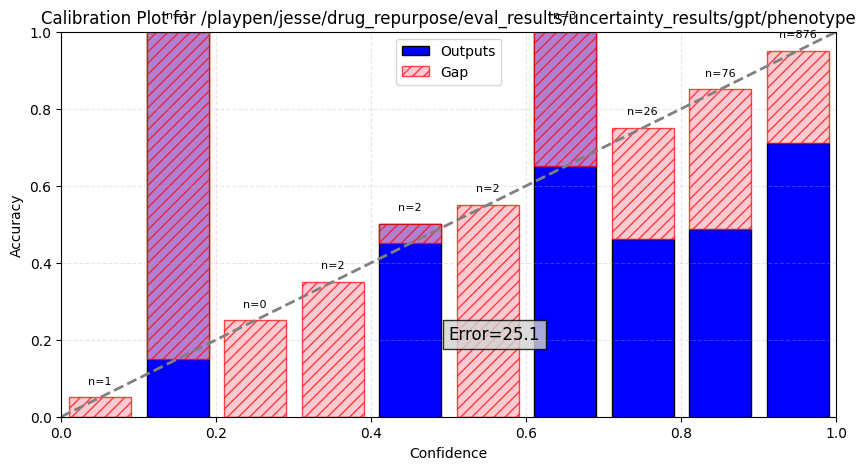

File: /playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/phenotype.jsonl, Calibration Error: 25.1


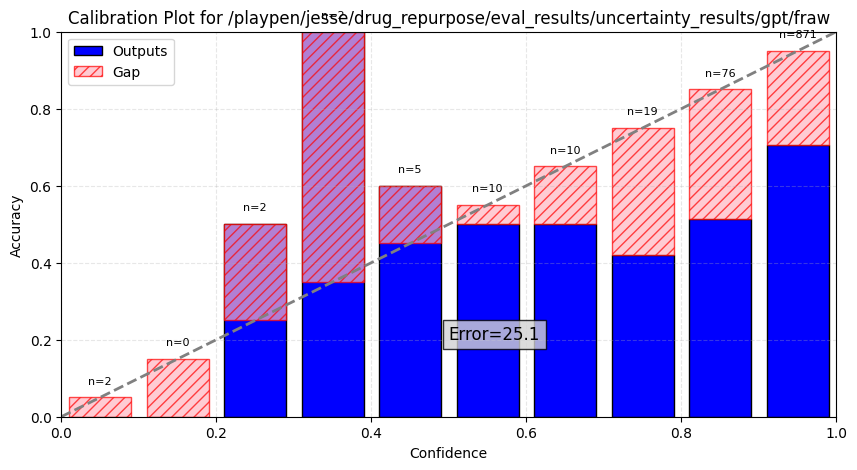

File: /playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/fraw.jsonl, Calibration Error: 25.1


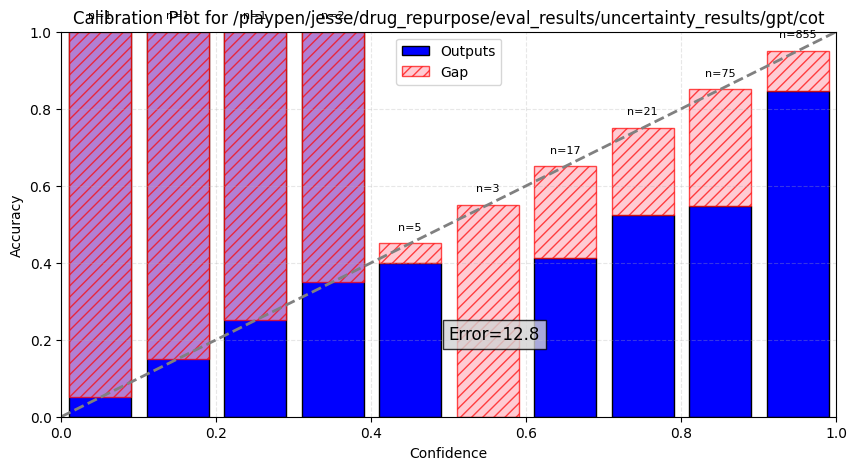

File: /playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/cot.jsonl, Calibration Error: 12.8


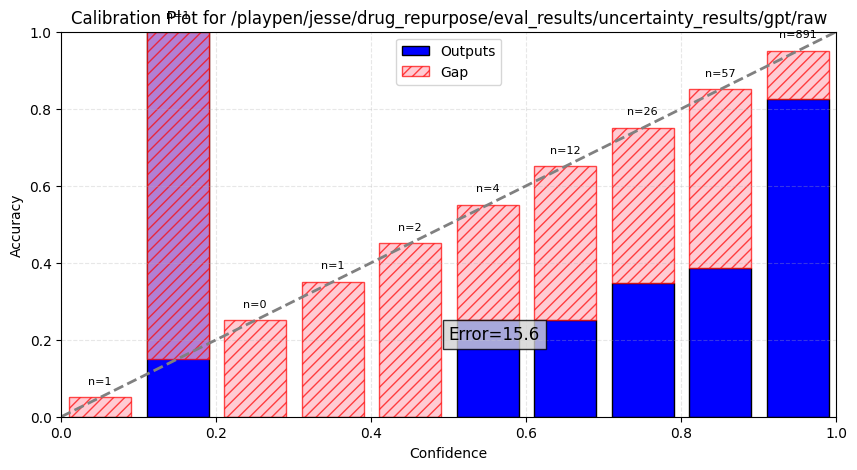

File: /playpen/jesse/drug_repurpose/eval_results/uncertainty_results/gpt/raw.jsonl, Calibration Error: 15.6


In [53]:
import jsonlines


for filename in all_files:
    file_path = os.path.join(folder_path, filename)
    f_data = []
    file_uncertainties = []
    file_accuracies = []
    with jsonlines.open(file_path) as reader:
        for obj in reader:
            f_data.append(obj)
            
    for line in f_data:
        answer = line['answer']
        groundth_truth = return_ground_truth(line['label'])
        if isinstance(answer, list):
            answer = answer[0]
        response = clean_answer(answer['output'])
        logprobs = answer['logprobs']
        tokens = logprobs['tokens']
        if response == None:
            continue

        response_prob = 0
        for tk in tokens:
            if response in tk.upper():
                response_prob = logprobs['token_logprobs'][tokens.index(tk)]

        acc_score = cal_acc(response, groundth_truth)

        file_uncertainties.append(response_prob)
        file_accuracies.append(acc_score)
    
    
    file_model_name = f"{os.path.splitext(filename)[0]}"
    file_error = create_calibration_plot(file_uncertainties, file_accuracies, file_model_name)
    print(f"File: {filename}, Calibration Error: {file_error}")
